**ВАЖНЫЙ КОММЕНТАРИЙ**

Обратите внимание:

* значения признака **work_shift** были изменены на 0 и 1. При желании можно удалить строку, которая это делает. Она находится в разделе "предобработка перед оценкой моделей и предсказыванием значений".

* супер выбросы удалил с помощью метода тройного интерквартильного размаха. (для этого была написана функция iqr_filter)

* Во время работы с датафреймом были сброшены индексы, из-за чего некоторые строки встали на иные индексы. Также значения столбца DateTime были изменены на числа в диапазоне от 0 до 1. **НО** данные проблемы я вроде как исправил(поставил строки на прежние индексы и перевёл значения столбца DateTime в тип datetime), поэтому проблем с этим быть не должно, если просто продолжить работать с датафреймом

* stage_4_output_danger_gas я тоже удалял, но добавил с учётом индексов. Вроде проблем вызвать не должен


# Подготовка данных для предсказания и замены чисел вместо пропусков

## Импорт библиотек

In [288]:
!pip install miceforest

In [289]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf
from sklearn.base import clone
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score


## Важные блоки кода. Функции/Классы

### **функции**

In [290]:
def nan_to_median(series: pd.Series):
  median_val = series.median()
  return series.fillna(median_val)


####################################################################################################


def radical_iqr_filter(df: pd.DataFrame, column: str, lower_bound=True, upper_bound=True, fill_nan=False, multp=3):
  """
  гибкая функция замены выбросов на NaN с помощью настраиваемого интерквартильного размаха

  Аргументы
      df: DataFrame содержащий данные, которые нужно отфильтровать.

      column: Название столбца в DataFrame df, в которомом будет производиться фильтрация.
      Функция будет рассчитывать IQR именно для этого столбца.

      lower_bound:  Булевый флаг, определяющий, следует ли отфильтровывать значения,
      лежащие ниже нижней границы, рассчитанной на основе IQR. То есть, если
      lower_bound = False, то все выбросы(если они есть) будут игнорироваться.

      upper_bound: Булевый флаг, определяющий, следует ли отфильтровывать значения,
      лежащие выше верхней границы, рассчитанной на основе IQR.

      multp: Множитель, используемый для расчета границ фильтрации.
  """
  df_copy = df.copy()

  if fill_nan:
    df_copy[column] = nan_to_median(df_copy[column])

  q1, q3 = np.percentile(df_copy[column], [25, 75])
  iqr = (q3 - q1) * multp
  low_bound = q1 - iqr
  up_bound = q3 + iqr

  outlines = 0 # индексы, значения строк столбца которых необходимо заменить медианой

  # в этих ситуациях мы ищем медиану среди чисел, которые не считаем за выбросы (1)
  # то есть мы считаем за выбросы up_bound или/и low_bound и не используем их диапазон значений
  # для поиска медианы.
  if lower_bound and upper_bound:
    outlines = df_copy[(df_copy[column] < low_bound) | (df_copy[column] > up_bound)].index
  elif lower_bound:
    outlines = df_copy[df_copy[column] < low_bound].index
  elif upper_bound:
    outlines = df_copy[df_copy[column] > up_bound].index

  df.loc[outlines, column] = np.nan


####################################################################################################


def super_train_test_split(df: pd.DataFrame, y: pd.Series):
    '''
    Делит данные на две выборки: 1. строки, значения необходимого нам столбца не имеют пропусков.
                                2. строки, значения необходимого нам столбца имеют пропуски.
    Каждый из этих пунктов так же делиться на две выборки: а) необходимый столбец.
                                                            б) остальные факторы.

    Аргументы:
        df: Pandas DataFrame, состоящий из факторов, инмеющих зависимость с признаком,
            в котором необходимо заполнить пропуски.

        y: Pandas Series, признак, пропуски которого необходимо заполнить.

    небольшой комментарий:
    У нас есть проблема - для заполенния пропусков с помощью какой-либо модели, необходимо,
    чтобы ВСЕ значения в других признаках были заполнены(не было пропусков).
    В противном случае модель ругается, что есть NaNы. Данный цикл устраняет данную проблему,
    временно заполняя пропуски в столбцах на медиану всех значений признака
    (кроме столбца, задача для которого изначально была заполнить пропуски с помощью модели).
    Дальше смотрите по комментариям
    '''
    X = df.copy()

    y_train = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X_train = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

    idxs = y_train.index # берём иднексы c изначально заполенными значениями
    X_test = X.drop(idxs) # отбрасываем строки с заполненными значениями в нужном нам столбце.
                        # Получается выборка с данными, на основе которых будут
                        # предсказываться пропущенные значения



    return X_train, X_test, y_train, y_temp


####################################################################################################


def split_for_grade(df: pd.DataFrame, target_column: pd.Series): # просто раздел данных на
                                                                 # выборки для обучения и тестирования
    X = df.copy()

    if target_column.name in X.columns:
        X.pop(target_column.name)
    y = target_column
    y1 = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков
    X = X.reset_index(drop=True)

    kernel = mf.ImputationKernel(
        data=X,
        random_state=42
    )
    y1 = y1.reset_index(drop=True)

    kernel.mice(iterations=1) # Количество итерация

    # Получаем датафрейм без пропусков
    X = kernel.complete_data()


    X_train, X_test, y_train, y_test = train_test_split(
        X, y1, test_size=len(y_temp) / len(y1), random_state=42)
    return X_train.values, X_test.values, y_train.values, y_test.values

### **Классы**

In [291]:
class SBS():
    """
    Класс для последовательного обратного отбора признаков (Sequential Backward Selection).

    Алгоритм отбирает подмножество наиболее важных признаков,
    оптимизируя модель по метрикам качества (R-квадрат и MSE).

    Аргументы:
        estimator: Модель машинного обучения, которую нужно оптимизировать.
                   Должна поддерживать методы fit и predict.
        k_features: Целевое количество признаков для отбора.
        test_size: Доля данных для тестирования (кросс-валидация).
        random_state: Случайное зерно для воспроизводимости результатов.

    """
    def __init__(self, estimator, k_features,
                test_size=0.25, random_state=42):
        self.estimator = clone(estimator) # Создаём копию модели, чтобы не менять исходную
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y, own_split=False):
        """
        Обучает модель SBS и отбирает лучшие признаки.

        Аргументы:
            X: Матрица признаков.
            y: Вектор целевой переменной.
            own_split: Если True, использует пользовательскую функцию split_for_grade для разделения данных.
        """

        # Разделение данных на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = split_for_grade(X, y)


        dim = X_train.shape[1]

        self.indices_ = list(range(dim))  # Индексы всех признаков
        self.subsets_ = [self.indices_] # Список всех подмножеств признаков

        # Вычисляем R-SQUARED и MSE
        score = self._calc_score(X_train, y_train,
                                    X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            # Перебор всех возможных подмножеств с одним удаленным признаком
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                            X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            # находим подмножества с лучшими значениями метрик
            best = np.argmax([i[0] for i in scores]) #  Выбираем подмножество с наибольшим r2_score,
                                                     # т.к. данная метрика в приоритете. Так же отбор
                                                     # лучшей комбинации будет происходит вне класса
            self.indices_ = subsets[best]
            #print(self.indices_)
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        """
        Возвращает матрицу признаков с отобранными признаками.

        Аргументы:
            X: Матрица признаков.
        """
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        """
        Вычисляет метрики R-SQUARED и MSE для заданного подмножества признаков.

        Аргументы:
            X_train, y_train, X_test, y_test, indices: Данные для обучения и оценки модели.
        """
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])

        score = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]
        return score


## Инициализация моделей и главного дата фрейма

инициализация регрессионных моделей и т.п.

In [292]:
knn_model = KNeighborsRegressor(n_neighbors=3)
random_forest = RandomForestRegressor(random_state=42)
scaler = MinMaxScaler()

In [293]:
df_environmental_data = pd.read_csv("analysing_environmental_issues.csv", sep=',') # главный датафрейм

In [294]:
#df_environmental_data

## предобработка перед оценкой моделей и предсказыванием значений

Просто копия главного датафрейма для экспериментов

In [295]:
df = df_environmental_data.copy()

Регрессионным моделям не нравится столбец DateTime, поэтому я его пока что просто удалил, но можно поставить в качестве индекса. DateTime сам по себе не очень полезен(на этапе предобработки).   

In [296]:
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
time_diffs = df['DateTime'].diff().dt.total_seconds()
time_diffs = time_diffs.fillna(0)

# нормализуем даты из столбца DateTime
normalized_diffs = scaler.fit_transform(time_diffs.values.reshape(-1, 1)).flatten()

# вычисляет кумулятивную сумму элементов
normalized_times = np.cumsum(normalized_diffs)

# подставляем нормализованные значение
df['DateTime'] = normalized_times

df.pop("stage_4_output_danger_gas") # значений мало, признак на данном этапе бесполезный.

df['work_shift'] = np.where(df['work_shift'] == 1.0, 0, 1)

df = df.drop_duplicates(subset=df.columns[1:], keep=False) # удаляем все дупликаты.
# Очень важно, что дубликаты будут найдены, если игнорировать столбец "DateTime".
df

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,0.000000,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,664.93,108.65,45.59,156.67,19.08,5.92,356.05,21.48,47.03,1
1,0.000413,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,671.68,108.71,45.89,156.76,19.15,5.94,357.69,21.48,45.05,1
2,0.000826,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,678.44,108.76,46.19,156.86,19.23,5.97,359.33,21.48,43.06,1
3,0.001239,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,717.99,108.63,45.87,156.41,19.36,5.97,339.99,21.48,46.01,1
4,0.001652,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,757.55,108.51,45.54,155.96,19.49,5.97,320.64,21.48,48.95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,7.729864,67.33,43.32,409.32,82.00,105.65,69.35,771.29,223.71,97.37,...,447.43,111.26,41.04,152.90,22.69,4.14,381.37,21.18,9.17,1
4396,7.734820,68.83,62.24,377.84,79.82,104.80,61.08,781.76,183.36,97.70,...,528.42,110.09,46.40,152.53,21.38,4.15,381.77,21.08,10.79,1
4397,7.739777,66.83,61.92,397.95,81.19,105.50,66.26,776.52,227.64,98.31,...,532.37,108.65,45.99,152.53,21.78,4.14,391.60,21.08,9.27,0
4398,7.745147,70.03,62.80,378.37,79.16,110.50,63.16,845.66,223.15,103.01,...,504.74,108.18,47.70,151.80,22.44,3.66,460.04,22.38,10.11,0


In [297]:
# удаляем супер выбросы/критические ошибки, так как такие значения
# могут непропорционально влиять на оценку параметров модели и
# вносить нестабильность в обучение модели. Для этого используем
# тройной межквартильный размах
for col in df.columns[1:-1]:
  radical_iqr_filter(df, col, fill_nan=True, multp=2)

#df.describe()

In [298]:
df

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,0.000000,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,664.93,108.65,45.59,156.67,19.08,5.92,356.05,21.48,47.03,1
1,0.000413,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,671.68,108.71,45.89,156.76,19.15,5.94,357.69,21.48,45.05,1
2,0.000826,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,678.44,108.76,46.19,NaN,19.23,5.97,359.33,21.48,43.06,1
3,0.001239,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,717.99,108.63,45.87,156.41,19.36,5.97,339.99,21.48,46.01,1
4,0.001652,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,757.55,108.51,45.54,155.96,19.49,5.97,320.64,21.48,48.95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,7.729864,67.33,43.32,409.32,82.00,105.65,69.35,NaN,223.71,97.37,...,447.43,111.26,41.04,152.90,22.69,4.14,381.37,21.18,NaN,1
4396,7.734820,68.83,62.24,377.84,79.82,104.80,61.08,NaN,183.36,97.70,...,528.42,110.09,46.40,152.53,21.38,4.15,381.77,21.08,10.79,1
4397,7.739777,66.83,61.92,397.95,81.19,105.50,66.26,NaN,227.64,98.31,...,532.37,108.65,45.99,152.53,21.78,4.14,391.60,21.08,NaN,0
4398,7.745147,70.03,62.80,378.37,79.16,110.50,63.16,NaN,223.15,103.01,...,504.74,108.18,47.70,151.80,22.44,3.66,460.04,22.38,10.11,0


In [299]:
#здесь небольшой костыль
df.loc[df['stage_3_input_soft_water'] > 620, 'stage_3_input_soft_water'] = np.nan
df.loc[df['stage_4_input_water'] > 650, 'stage_4_input_water'] = np.nan

Было протестированно множество разных моделей. В конченом счёте лучшими моделями оказались KNN и Random Trees Forest. В ходе размышлений было принято использовать KNN для тех признаков, если метрики R-SQUAED и MSE показали хорошие значения в тестовых выборках. Для отбора признаков в зависимости от которых будут предсказываться значения на месте пропусков в отклике.

## **SBS  для выбора факторов , на основе которых буддет обучаться модель и предсказываться значения**

**KNeighborsRegressor**

In [300]:
columns_dict_NaN_for_CNN = {}
columns_dict_NaN_for_RFR = {}

In [301]:
index_list = df.index.tolist()
index_series = pd.Series(index_list)
df = df.reset_index(drop=True)

In [302]:
# очень кратко: находим лучшую комбинацию факторов, на основе которых будем
# предсказывать значения на местах пропусков. Таких столбцов может не быть
sbs = SBS(knn_model, k_features=1)

for column in df.columns:
    if df[column].isnull().any() == True:
        y = df[column]
        X = df.copy()
        X.pop(column)

        new_names = [i for i in range(len(df.columns))]

        sbs.fit(X, y, own_split=True)

        X = X.rename(columns=dict(zip(X, new_names)))

        k_feat = []
        r2 = []
        mse = []

        for scores in sbs.scores_:
            k_feat.append(len(sbs.subsets_[sbs.scores_.index(scores)]))
            r2.append(scores[0])
            mse.append(scores[1])
            #else:
            #   print(column)
            #   print(f"R2: {scores[0]}, MSE {scores[1]}")


        # нормализация MSE
        mse_values = np.array([item[1] for item in sbs.scores_])
        scaler = MinMaxScaler()
        mse_values_normalized = scaler.fit_transform(mse_values.reshape(-1, 1)).flatten()

        best_r2 = -1
        best_mse = float('inf')
        best_pair = None
        lk = -1
        for i, (r2_sc, mse_sc) in enumerate(sbs.scores_):
            normalized_mse = mse_values_normalized[i]
            rounded_mse = round(normalized_mse, 3)

            if r2_sc > best_r2 and rounded_mse < best_mse:
                best_r2 = r2_sc
                best_mse = rounded_mse
                best_pair = [r2_sc, mse_sc]
                lk = list(sbs.subsets_[sbs.scores_.index([r2_sc, mse_sc])])
        if df.columns.get_loc(y.name) in lk:
            index = lk.index(df.columns.get_loc(y.name))
            lk = np.array(lk)
            if index < len(lk) - 1:
                lk = np.concatenate((lk[:index], lk[index:] + 1))
            else:
                lk = lk[:index]
        else:
            for i in range(len(lk)):
                if lk[i] > df.columns.get_loc(y.name):
                    lk[i] += 1

        print(column)
        print(f"Лучшее кол-во признаков: {lk}")
        print(f"Лучшая пара метрик: R2 = {best_pair[0]:.4f}, MSE = {best_pair[1]:.4f}, Normalized MSE = {best_mse:.4f}")
        print('=-----------------------------------------------')

        if best_pair[0] > 0.7 and best_pair[1] < 50:
            columns_dict_NaN_for_CNN[column] = [col for col in list(df.columns[0:][lk]) if col != column]
        else:
            columns_dict_NaN_for_RFR[column] = [col for col in list(df.columns[0:][lk]) if col != column]

        # ДОЛЖЕН БЫТЬ НЕ DF А X!!!! [1, 2 n(удалить)]

print(columns_dict_NaN_for_CNN)
print(columns_dict_NaN_for_RFR)


[3, 5, 7, 8, 9, 10, 13]
stage_1_output_konv_avd
Лучшее кол-во признаков: [3, 5, 7, 8, 9, 10, 13]
Лучшая пара метрик: R2 = 0.8519, MSE = 2.0596, Normalized MSE = 0.0000
=-----------------------------------------------
2
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
stage_2_input_water_sum
Лучшее кол-во признаков: [ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Лучшая пара метрик: R2 = 0.9584, MSE = 29.5857, Normalized MSE = 0.0000
=-----------------------------------------------
3
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 19 20 21]
[ 0  1  2  4  5  6  7  8  9 10 11 12 14 15 16 17 18 20 21 22]
stage_2_output_bottom_pressure
Лучшее кол-во признаков: [ 0  1  2  4  5  6  7  8  9 10 11 12 14 15 16 17 18 20 21 22]
Лучшая пара метрик: R2 = 0.9759, MSE = 92.9710, Normalized MSE = 0.0000
=-----------------------------------------------
3
[ 0  1  3  4  5  6  8  9 10 13 15 16 17 19 20 21]

In [303]:
#print(len(columns_dict_NaN_for_CNN.keys()))
#print(len(columns_dict_NaN_for_RFR.keys()))

# Замена пропусков

In [304]:
#df

In [305]:
df1 = df.copy()

In [306]:
df = df1.copy()

в качестве моделей, которые будут заменять пропуски в данных, будут использоваться KNN и MICE

In [307]:
for column in columns_dict_NaN_for_CNN.keys(): # для каждого столбца в котором остались пропущенные значения

    X = df.loc[:, columns_dict_NaN_for_CNN[column]].copy() # все зависимые признаки с столбцом column ()
    kernel = mf.ImputationKernel(
        data=X,
        random_state=42
    )

    kernel.mice(iterations=5) # Количество итерация

    # Получаем датафрейм без пропусков
    X = kernel.complete_data()

    y = df[column] # наш столбец.

    X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    knn_model.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)

    y_pred = knn_model.predict(X_test) # предсказываем пропущенные значения

    df.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений

In [308]:
df2 = df.copy()

In [309]:
df = df2.copy()

In [310]:
for column in columns_dict_NaN_for_RFR.keys(): # для каждого столбца в котором остались пропущенные значения
    df_temp = df.copy()

    y = df[column] # наш столбец.

    kernel = mf.ImputationKernel(data=df_temp, random_state=42)
    kernel.mice(iterations=5)
    df_temp = kernel.complete_data()
    X = df_temp.loc[:, columns_dict_NaN_for_RFR[column]].copy()

    X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    random_forest.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)

    y_pred = random_forest.predict(X_test) # предсказываем пропущенные значения

    df.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений


In [311]:
df.shape

(4240, 23)

----------------------------
stage_2_output_bottom_pressure - r2: 0.9731576495359902, mse: 90.20362404765893


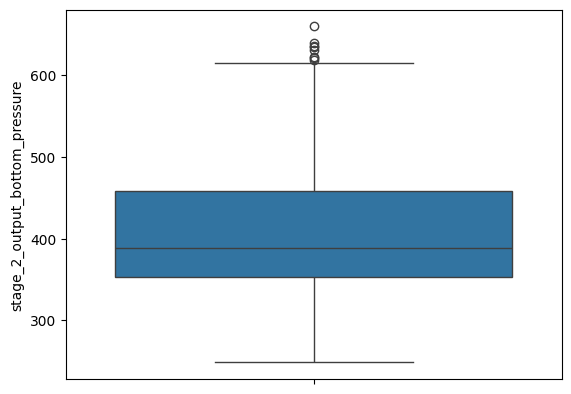

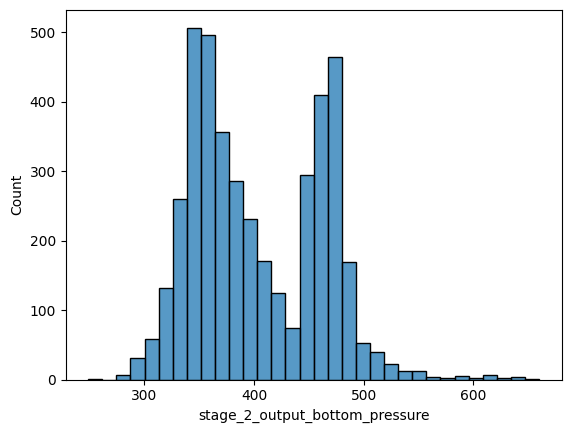

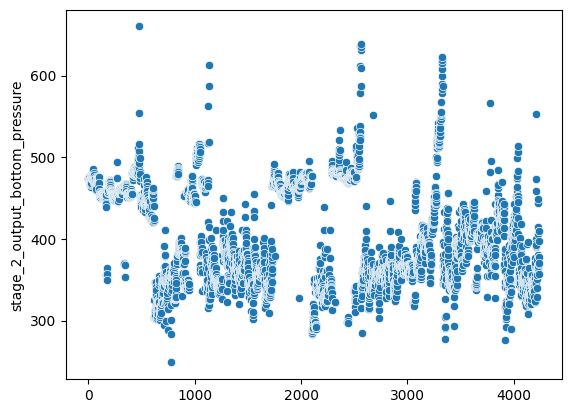

----------------------------
stage_3_input_soft_water - r2: 0.9476433036320786, mse: 804.2069667234258


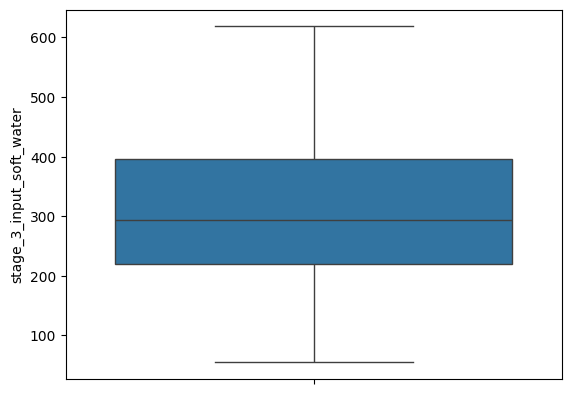

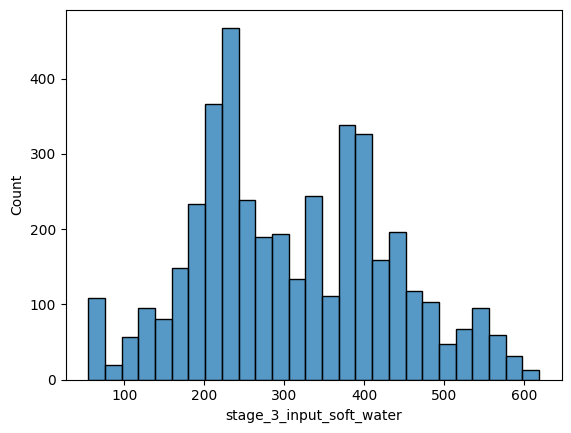

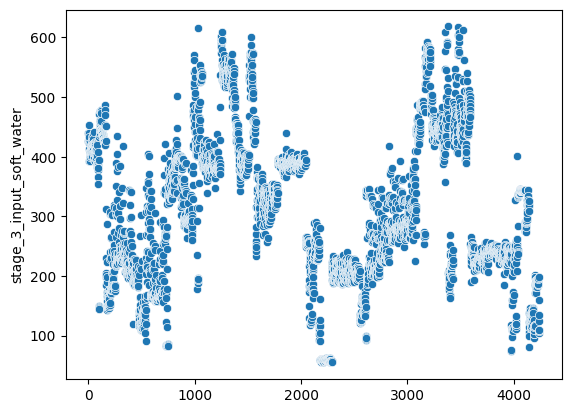

----------------------------
stage_3_input_steam - r2: 0.9734025933923129, mse: 2605.0219140317286


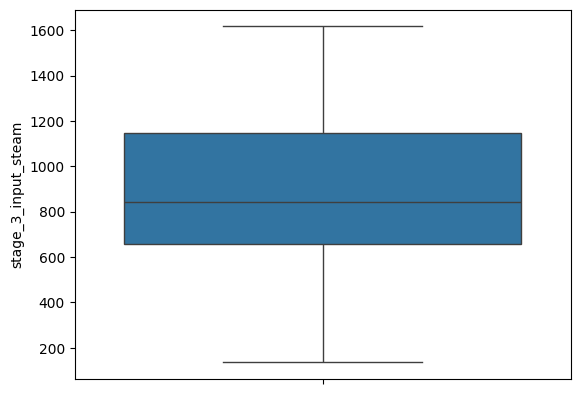

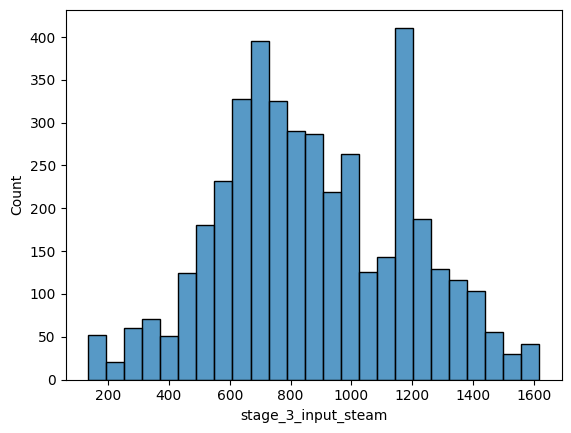

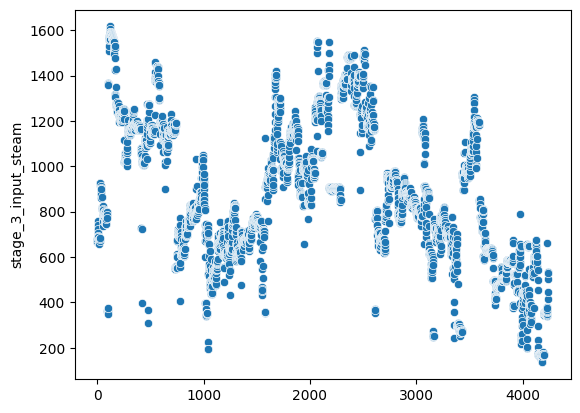

----------------------------
stage_4_input_water - r2: 0.9130064201142813, mse: 907.8168401735825


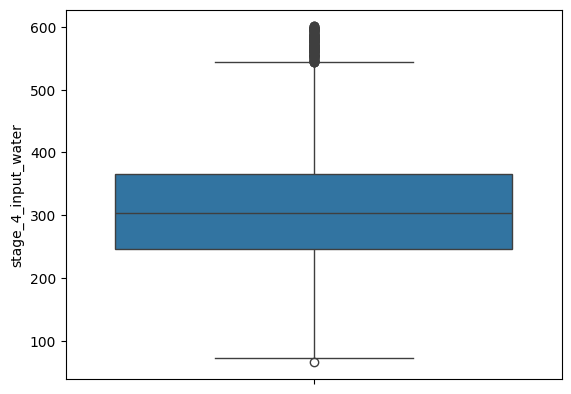

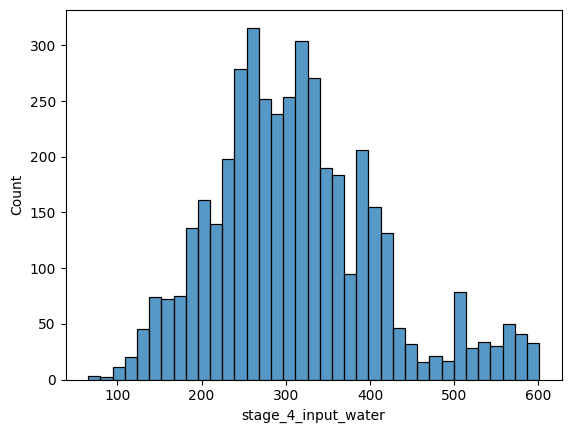

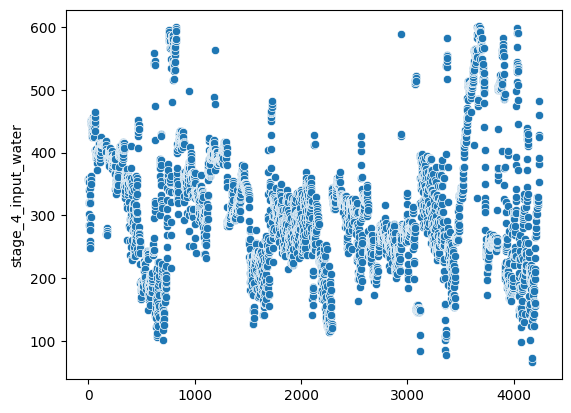

In [312]:
'''
for column in columns_dict_NaN_for_RFR.keys(): # для каждого столбца в котором остались пропущенные значения

    X = df.loc[:, columns_dict_NaN_for_RFR[column]].copy()
    y = df[column] # наш столбец.

    X_train, X_test, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    random_forest.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)
    y_pred = random_forest.predict(X_test) # предсказываем пропущенные значения

    r2 = r2_score(y_temp, y_pred)
    mse = mean_squared_error(y_temp, y_pred)

    print("----------------------------")
    print(f'{column} - r2: {r2}, mse: {mse}')
    if mse > 0:
        sns.boxplot(df[column])
        plt.show()
        sns.histplot(df[column])
        plt.show()
        sns.scatterplot(df[column])
        plt.show()

'''

In [313]:
'''
for column in columns_dict_NaN_for_CNN.keys(): # для каждого столбца в котором остались пропущенные значения

    X = df.loc[:, columns_dict_NaN_for_CNN[column]].copy()
    y = df[column] # наш столбец.

    X_train, X_test, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    knn_model.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)
    y_pred = knn_model.predict(X_test) # предсказываем пропущенные значения

    r2 = r2_score(y_temp, y_pred)
    mse = mean_squared_error(y_temp, y_pred)
    print("----------------------------")
    print(f'{column} - r2: {r2}, mse: {mse}')

'''

----------------------------
stage_1_output_konv_avd - r2: 0.6977587626029135, mse: 4.747981597950151
----------------------------
stage_2_input_water_sum - r2: 0.8777703342588059, mse: 98.86739753232006
----------------------------
stage_2_output_bottom_temp - r2: 0.9603803976905724, mse: 0.2856718189494525
----------------------------
stage_2_output_bottom_temp_hum_steam - r2: 0.8552255036425287, mse: 11.269658382832516
----------------------------
stage_2_output_bottom_vacuum - r2: 0.9333025783133136, mse: 3.572377683146983
----------------------------
stage_2_output_top_pressure - r2: 0.8912034002648794, mse: 293.63492505532264
----------------------------
stage_2_output_top_pressure_at_end - r2: 0.880100420302692, mse: 181.4353187427207
----------------------------
stage_2_output_top_temp - r2: 0.8931969218886707, mse: 1.6347403767761481
----------------------------
stage_2_output_top_vacuum - r2: 0.9141054927443056, mse: 10.582886584265083
----------------------------
stage_3_inp

In [314]:
df.isnull().any()

,0
DateTime,False
stage_1_output_konv_avd,False
stage_2_input_water_sum,False
stage_2_output_bottom_pressure,False
stage_2_output_bottom_temp,False
stage_2_output_bottom_temp_hum_steam,False
stage_2_output_bottom_vacuum,False
stage_2_output_top_pressure,False
stage_2_output_top_pressure_at_end,False
stage_2_output_top_temp,False


In [315]:
#df

In [316]:
df = df.set_index(index_series) # заменяем сброшенные индесы на старые для корректной работы.

In [317]:
# создаём фактор с значения столбца DateTime типа datetime
date_series = pd.to_datetime(df_environmental_data['DateTime'].copy(), errors='coerce')
#date_series

In [318]:
df["DateTime"] = date_series.loc[df.index] # подстановка значений типа datetime
#df["DateTime"]

In [319]:
# добавляем столб stage_4_output_danger_gas
df["stage_4_output_danger_gas"] = df_environmental_data['stage_4_output_danger_gas'].loc[df.index]
#df["stage_4_output_danger_gas"]

# Как интегрировать это чюдо в свой код

Код работает, вроде все проблемные ситуации, которые нашёл, устранил. Я молодец

Насколько я понимаю, вам достаточно скопировать всё эти махинации в самое начало вашего блокнота и после последней строчки моего кода написать
"название вашей переменной с датафреймом" = df


In [320]:
#my_data = df

Код работает довольно медленно. Лишний раз его лучше не запускать. Наверное можно записать данный обработанный массив в csv файл и работать уже с ним.

In [321]:
df.to_csv("analysing_environmental_without_nan_values", encoding='utf-8', index=False)